In [2]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [3]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [4]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [5]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run2"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_HP_Wrapper(DEVICE, classifier, input_dim,
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_pairwise_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6588372529721728


Iterations:   0%|                                   | 1/300 [00:03<15:10,  3.04s/it]

Epoch:  0
t_loss:  0.6588372529721728 , v_loss:  0.6944884061813354
t_acc:  0.556178026766262 , v_acc:  0.37267080745341613
t_recall:  0.4794231481862725 , v_recall:  0.4626126126126126
t_prec:  0.47969799884626946 , v_prec:  0.4571280991735537
t_f:  0.4795301190038032 , v_f:  0.3702412764803842
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:38,  1.74s/it]

Epoch  1 , loss 0.6270641754655277
Epoch  2 , loss 0.6034279395552242


Iterations:   1%|▎                                  | 3/300 [00:05<07:41,  1.55s/it]

Epoch:  2
t_loss:  0.6034279395552242 , v_loss:  0.6909269491831461
t_acc:  0.6333644568938687 , v_acc:  0.5962732919254659
t_recall:  0.48918625876669275 , v_recall:  0.4599099099099099
t_prec:  0.4804777447777121 , v_prec:  0.4345588235294118
t_f:  0.46593324535965175 , v_f:  0.43508771929824563
////////


Iterations:   1%|▍                                  | 4/300 [00:06<06:15,  1.27s/it]

Epoch  3 , loss 0.5774232441303777
Epoch  4 , loss 0.5589838512972289


Iterations:   2%|▌                                  | 5/300 [00:07<06:22,  1.30s/it]

Epoch:  4
t_loss:  0.5589838512972289 , v_loss:  0.6787804365158081
t_acc:  0.6704014939309056 , v_acc:  0.6894409937888198
t_recall:  0.4953932831006986 , v_recall:  0.5
t_prec:  0.4810599078341014 , v_prec:  0.3447204968944099
t_f:  0.44034600656702577 , v_f:  0.4080882352941176
////////


Iterations:   2%|▋                                  | 6/300 [00:08<05:38,  1.15s/it]

Epoch  5 , loss 0.5415731761969772
Epoch  6 , loss 0.523426937121971


Iterations:   2%|▊                                  | 7/300 [00:09<06:06,  1.25s/it]

Epoch:  6
t_loss:  0.523426937121971 , v_loss:  0.6629521449406942
t_acc:  0.6887643946467475 , v_acc:  0.6894409937888198
t_recall:  0.5025541785042753 , v_recall:  0.5
t_prec:  0.5240350257871762 , v_prec:  0.3447204968944099
t_f:  0.431674263210699 , v_f:  0.4080882352941176
////////


Iterations:   3%|▉                                  | 8/300 [00:10<05:32,  1.14s/it]

Epoch  7 , loss 0.5107652954026765
Epoch  8 , loss 0.5012216410216164


Iterations:   3%|█                                  | 9/300 [00:11<05:51,  1.21s/it]

Epoch:  8
t_loss:  0.5012216410216164 , v_loss:  0.65363077322642
t_acc:  0.6921879863056334 , v_acc:  0.6894409937888198
t_recall:  0.5001269540632163 , v_recall:  0.5
t_prec:  0.5030053283659678 , v_prec:  0.3447204968944099
t_f:  0.41768443922621 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:12<05:18,  1.10s/it]

Epoch  9 , loss 0.49012942524517283
Epoch  10 , loss 0.48453689264316185


Iterations:   4%|█▏                                | 11/300 [00:14<05:48,  1.21s/it]

Epoch:  10
t_loss:  0.48453689264316185 , v_loss:  0.6523837546507517
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5010540618437848 , v_recall:  0.5
t_prec:  0.5480300187617261 , v_prec:  0.3447204968944099
t_f:  0.41576068370365055 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:15<05:17,  1.10s/it]

Epoch  11 , loss 0.47351770015323863
Epoch  12 , loss 0.4678191653653687


Iterations:   4%|█▍                                | 13/300 [00:16<05:42,  1.19s/it]

Epoch:  12
t_loss:  0.4678191653653687 , v_loss:  0.6544239322344462
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49990392665486333 , v_recall:  0.5
t_prec:  0.49064254522769807 , v_prec:  0.3447204968944099
t_f:  0.4118815871597207 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:17<05:10,  1.09s/it]

Epoch  13 , loss 0.4643842373408523
Epoch  14 , loss 0.4598363935947418


Iterations:   5%|█▋                                | 15/300 [00:18<05:32,  1.17s/it]

Epoch:  14
t_loss:  0.4598363935947418 , v_loss:  0.6565255622069041
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:09,  1.09s/it]

Epoch  15 , loss 0.4575464614466125
Epoch  16 , loss 0.45532119916934594


Iterations:   6%|█▉                                | 17/300 [00:21<05:37,  1.19s/it]

Epoch:  16
t_loss:  0.45532119916934594 , v_loss:  0.6584621667861938
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:21<05:08,  1.09s/it]

Epoch  17 , loss 0.4496247482066061
Epoch  18 , loss 0.4516177831911573


Iterations:   6%|██▏                               | 19/300 [00:23<05:31,  1.18s/it]

Epoch:  18
t_loss:  0.4516177831911573 , v_loss:  0.6597612202167511
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.500063820150698 , v_recall:  0.5
t_prec:  0.5144859813084112 , v_prec:  0.3447204968944099
t_f:  0.4111203780928551 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:24<05:06,  1.10s/it]

Epoch  19 , loss 0.4450153538993761
Epoch  20 , loss 0.44272537412596685


Iterations:   7%|██▍                               | 21/300 [00:25<05:41,  1.23s/it]

Epoch:  20
t_loss:  0.44272537412596685 , v_loss:  0.6608207722504934
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5005750675944607 , v_recall:  0.5
t_prec:  0.5979277033343721 , v_prec:  0.3447204968944099
t_f:  0.4122130008035903 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:24,  1.17s/it]

Epoch  21 , loss 0.4419344482468624
Epoch  22 , loss 0.44174012775514643


Iterations:   8%|██▌                               | 23/300 [00:28<05:49,  1.26s/it]

Epoch:  22
t_loss:  0.44174012775514643 , v_loss:  0.6611713469028473
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.49955257270693515 , v_recall:  0.5
t_prec:  0.3477109934599813 , v_prec:  0.3447204968944099
t_f:  0.41002570694087404 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:29<05:31,  1.20s/it]

Epoch  23 , loss 0.4428362297076805
Epoch  24 , loss 0.4417576339899325


Iterations:   8%|██▊                               | 25/300 [00:30<05:50,  1.28s/it]

Epoch:  24
t_loss:  0.4417576339899325 , v_loss:  0.6606305340925852
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.4998401065041655 , v_recall:  0.5
t_prec:  0.47277189155500154 , v_prec:  0.3447204968944099
t_f:  0.41101098240032563 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:31<05:21,  1.17s/it]

Epoch  25 , loss 0.4392092257153754
Epoch  26 , loss 0.43878350012442646


Iterations:   9%|███                               | 27/300 [00:33<05:42,  1.25s/it]

Epoch:  26
t_loss:  0.43878350012442646 , v_loss:  0.6570855577786764
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5025562372188139 , v_recall:  0.5
t_prec:  0.8483478802992519 , v_prec:  0.3447204968944099
t_f:  0.415705613844319 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:34<05:17,  1.17s/it]

Epoch  27 , loss 0.4408907411145229
Epoch  28 , loss 0.4369681237959394


Iterations:  10%|███▎                              | 29/300 [00:35<05:38,  1.25s/it]

Epoch:  28
t_loss:  0.4369681237959394 , v_loss:  0.6537707994381586
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5007987812409931 , v_recall:  0.5
t_prec:  0.6813084112149532 , v_prec:  0.3447204968944099
t_f:  0.41232340081380947 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:36<05:12,  1.16s/it]

Epoch  29 , loss 0.43765559967826395
Epoch  30 , loss 0.444754688763151


Iterations:  10%|███▌                              | 31/300 [00:37<05:28,  1.22s/it]

Epoch:  30
t_loss:  0.444754688763151 , v_loss:  0.6514713714520136
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.503418838610505 , v_recall:  0.5
t_prec:  0.7121685310317416 , v_prec:  0.3447204968944099
t_f:  0.4186094863993165 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:06,  1.14s/it]

Epoch  31 , loss 0.43975619182867165
Epoch  32 , loss 0.4425914889457179


Iterations:  11%|███▋                              | 33/300 [00:40<05:27,  1.23s/it]

Epoch:  32
t_loss:  0.4425914889457179 , v_loss:  0.6450540473063787
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5018850962792166 , v_recall:  0.5
t_prec:  0.6607059282371295 , v_prec:  0.3447204968944099
t_f:  0.4153651115618661 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:41<05:03,  1.14s/it]

Epoch  33 , loss 0.43537066029567345
Epoch  34 , loss 0.43163998337352977


Iterations:  12%|███▉                              | 35/300 [00:42<05:21,  1.21s/it]

Epoch:  34
t_loss:  0.43163998337352977 , v_loss:  0.6430531690518061
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5041537997008002 , v_recall:  0.5
t_prec:  0.7577792288910341 , v_prec:  0.3447204968944099
t_f:  0.4198045337037372 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:43<04:54,  1.12s/it]

Epoch  35 , loss 0.4368969353975034
Epoch  36 , loss 0.4320751709096572


Iterations:  12%|████▏                             | 37/300 [00:44<05:15,  1.20s/it]

Epoch:  36
t_loss:  0.4320751709096572 , v_loss:  0.6393813838561376
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:45<04:50,  1.11s/it]

Epoch  37 , loss 0.4312775631745656
Epoch  38 , loss 0.4292441349403531


Iterations:  13%|████▍                             | 39/300 [00:47<05:20,  1.23s/it]

Epoch:  38
t_loss:  0.4292441349403531 , v_loss:  0.63514976700147
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5019489164299145 , v_recall:  0.5
t_prec:  0.6209471353131566 , v_prec:  0.3447204968944099
t_f:  0.416219391790475 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:48<04:48,  1.11s/it]

Epoch  39 , loss 0.43212515291045694
Epoch  40 , loss 0.43356091543739916


Iterations:  14%|████▋                             | 41/300 [00:49<05:04,  1.18s/it]

Epoch:  40
t_loss:  0.43356091543739916 , v_loss:  0.6282893270254135
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.503355018459807 , v_recall:  0.5
t_prec:  0.7860179407176286 , v_prec:  0.3447204968944099
t_f:  0.4177611561866126 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:36,  1.07s/it]

Epoch  41 , loss 0.4262537132291233
Epoch  42 , loss 0.43020996685121576


Iterations:  14%|████▊                             | 43/300 [00:51<05:00,  1.17s/it]

Epoch:  42
t_loss:  0.43020996685121576 , v_loss:  0.622464969754219
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5032589451146704 , v_recall:  0.5
t_prec:  0.6484990619136961 , v_prec:  0.3447204968944099
t_f:  0.41933401285531013 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:39,  1.09s/it]

Epoch  43 , loss 0.42461175310845467
Epoch  44 , loss 0.433812757917479


Iterations:  15%|█████                             | 45/300 [00:53<04:56,  1.16s/it]

Epoch:  44
t_loss:  0.433812757917479 , v_loss:  0.6175761222839355
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5031313048132746 , v_recall:  0.5
t_prec:  0.7373595505617978 , v_prec:  0.3447204968944099
t_f:  0.41764560913497084 , v_f:  0.4080882352941176
////////


Iterations:  15%|█████▏                            | 46/300 [00:54<04:32,  1.07s/it]

Epoch  45 , loss 0.4301140886895797
Epoch  46 , loss 0.4250113145977843


Iterations:  16%|█████▎                            | 47/300 [00:56<04:50,  1.15s/it]

Epoch:  46
t_loss:  0.4250113145977843 , v_loss:  0.6130970319112142
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.503035231468138 , v_recall:  0.5
t_prec:  0.6297016734438536 , v_prec:  0.3447204968944099
t_f:  0.4192163289012425 , v_f:  0.4080882352941176
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:35,  1.09s/it]

Epoch  47 , loss 0.4308932715771245
Epoch  48 , loss 0.42464394779766307


Iterations:  16%|█████▌                            | 49/300 [00:58<04:50,  1.16s/it]

Epoch:  48
t_loss:  0.42464394779766307 , v_loss:  0.6072529604037603
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5053677550404194 , v_recall:  0.5
t_prec:  0.66713199054158 , v_prec:  0.3447204968944099
t_f:  0.4244312569111685 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:30,  1.08s/it]

Epoch  49 , loss 0.41784333598379997
Epoch  50 , loss 0.42809615298813464


Iterations:  17%|█████▊                            | 51/300 [01:00<04:50,  1.16s/it]

Epoch:  50
t_loss:  0.42809615298813464 , v_loss:  0.6065477033456167
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5061027161307147 , v_recall:  0.5
t_prec:  0.6900159539614256 , v_prec:  0.3447204968944099
t_f:  0.4256155547364541 , v_f:  0.4080882352941176
////////


Iterations:  17%|█████▉                            | 52/300 [01:01<04:31,  1.10s/it]

Epoch  51 , loss 0.42823996789315166
Epoch  52 , loss 0.41643141063989375


Iterations:  18%|██████                            | 53/300 [01:02<04:52,  1.19s/it]

Epoch:  52
t_loss:  0.41643141063989375 , v_loss:  0.5990325758854548
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.507636458462003 , v_recall:  0.51
t_prec:  0.709435382685069 , v_prec:  0.846875
t_f:  0.4287888685042053 , v_f:  0.42920193907821425
////////


Iterations:  18%|██████                            | 54/300 [01:03<04:36,  1.12s/it]

Epoch  53 , loss 0.41991110292135503
Epoch  54 , loss 0.41735101388949974


Iterations:  18%|██████▏                           | 55/300 [01:05<05:00,  1.23s/it]

Epoch:  54
t_loss:  0.41735101388949974 , v_loss:  0.5948314716418585
t_acc:  0.7005913476501712 , v_acc:  0.6956521739130435
t_recall:  0.5090425604918956 , v_recall:  0.51
t_prec:  0.7815518076408079 , v_prec:  0.846875
t_f:  0.43035274603759677 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▎                           | 56/300 [01:06<04:34,  1.12s/it]

Epoch  55 , loss 0.424089288594676
Epoch  56 , loss 0.4166510923236024


Iterations:  19%|██████▍                           | 57/300 [01:07<04:59,  1.23s/it]

Epoch:  56
t_loss:  0.4166510923236024 , v_loss:  0.5918692797422409
t_acc:  0.7021475256769374 , v_acc:  0.6956521739130435
t_recall:  0.5133240004940914 , v_recall:  0.51
t_prec:  0.7352770103242694 , v_prec:  0.846875
t_f:  0.44103485341539905 , v_f:  0.42920193907821425
////////


Iterations:  19%|██████▌                           | 58/300 [01:08<04:38,  1.15s/it]

Epoch  57 , loss 0.4163934348845014
Epoch  58 , loss 0.41414367568259147


Iterations:  20%|██████▋                           | 59/300 [01:10<04:57,  1.23s/it]

Epoch:  58
t_loss:  0.41414367568259147 , v_loss:  0.5880203892787298
t_acc:  0.7002801120448179 , v_acc:  0.6956521739130435
t_recall:  0.5105440496287452 , v_recall:  0.51
t_prec:  0.7072057898049088 , v_prec:  0.846875
t_f:  0.4357266490728602 , v_f:  0.42920193907821425
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:33,  1.14s/it]

Epoch  59 , loss 0.41811009715585146
Epoch  60 , loss 0.4173612314112046


Iterations:  20%|██████▉                           | 61/300 [01:12<04:53,  1.23s/it]

Epoch:  60
t_loss:  0.4173612314112046 , v_loss:  0.5840185135602951
t_acc:  0.7033924680983504 , v_acc:  0.7080745341614907
t_recall:  0.5159440578636033 , v_recall:  0.53
t_prec:  0.7342105616859989 , v_prec:  0.8512658227848101
t_f:  0.44689754833115813 , v_f:  0.4692431787893666
////////


Iterations:  21%|███████                           | 62/300 [01:13<04:34,  1.15s/it]

Epoch  61 , loss 0.41825930686557994
Epoch  62 , loss 0.41514412620488333


Iterations:  21%|███████▏                          | 63/300 [01:14<04:58,  1.26s/it]

Epoch:  62
t_loss:  0.41514412620488333 , v_loss:  0.5790542215108871
t_acc:  0.7018362900715842 , v_acc:  0.7142857142857143
t_recall:  0.513100286847559 , v_recall:  0.54
t_prec:  0.7256145603529782 , v_prec:  0.8535031847133758
t_f:  0.44089706292649467 , v_f:  0.488253178551686
////////


Iterations:  21%|███████▎                          | 64/300 [01:15<04:36,  1.17s/it]

Epoch  63 , loss 0.41212455490056205
Epoch  64 , loss 0.4142020338890599


Iterations:  22%|███████▎                          | 65/300 [01:17<04:58,  1.27s/it]

Epoch:  64
t_loss:  0.4142020338890599 , v_loss:  0.5756745090087255
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5114704711711341 , v_recall:  0.54
t_prec:  0.6798136779597808 , v_prec:  0.8535031847133758
t_f:  0.4391825436257262 , v_f:  0.488253178551686
////////


Iterations:  22%|███████▍                          | 66/300 [01:18<04:43,  1.21s/it]

Epoch  65 , loss 0.4112520323080175
Epoch  66 , loss 0.41447300361652


Iterations:  22%|███████▌                          | 67/300 [01:20<05:01,  1.29s/it]

Epoch:  66
t_loss:  0.41447300361652 , v_loss:  0.5724408179521561
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5147616694802433 , v_recall:  0.55
t_prec:  0.7081226295828066 , v_prec:  0.8557692307692308
t_f:  0.4454523205909422 , v_f:  0.5066394279877425
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:41,  1.21s/it]

Epoch  67 , loss 0.41277439746202205
Epoch  68 , loss 0.4119543152696946


Iterations:  23%|███████▊                          | 69/300 [01:22<04:55,  1.28s/it]

Epoch:  68
t_loss:  0.4119543152696946 , v_loss:  0.5671190420786539
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5224303811366849 , v_recall:  0.56
t_prec:  0.7432766354398221 , v_prec:  0.8580645161290323
t_f:  0.4605032184648906 , v_f:  0.5244360902255639
////////


Iterations:  23%|███████▉                          | 70/300 [01:23<04:32,  1.18s/it]

Epoch  69 , loss 0.41172919027945576
Epoch  70 , loss 0.41125162968448564


Iterations:  24%|████████                          | 71/300 [01:24<04:46,  1.25s/it]

Epoch:  70
t_loss:  0.41125162968448564 , v_loss:  0.5657220631837845
t_acc:  0.7058823529411765 , v_acc:  0.7329192546583851
t_recall:  0.5226218415887787 , v_recall:  0.5700000000000001
t_prec:  0.7157207049995638 , v_prec:  0.8603896103896104
t_f:  0.4625211869094771 , v_f:  0.5416749420721615
////////


Iterations:  24%|████████▏                         | 72/300 [01:25<04:30,  1.19s/it]

Epoch  71 , loss 0.4082515175436057
Epoch  72 , loss 0.401457337772145


Iterations:  24%|████████▎                         | 73/300 [01:27<04:48,  1.27s/it]

Epoch:  72
t_loss:  0.401457337772145 , v_loss:  0.5627522220214208
t_acc:  0.7096171802054155 , v_acc:  0.7391304347826086
t_recall:  0.527894209522241 , v_recall:  0.58
t_prec:  0.7462659439548278 , v_prec:  0.8627450980392157
t_f:  0.4717688866302628 , v_f:  0.5583855799373041
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:21,  1.16s/it]

Epoch  73 , loss 0.4078880934154286
Epoch  74 , loss 0.4078290065129598


Iterations:  25%|████████▌                         | 75/300 [01:29<04:34,  1.22s/it]

Epoch:  74
t_loss:  0.4078290065129598 , v_loss:  0.5602569629748663
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.5256893262513553 , v_recall:  0.58
t_prec:  0.7267999806127972 , v_prec:  0.8627450980392157
t_f:  0.4683719019783674 , v_f:  0.5583855799373041
////////


Iterations:  25%|████████▌                         | 76/300 [01:30<04:13,  1.13s/it]

Epoch  75 , loss 0.4036301064725016
Epoch  76 , loss 0.4038512473012887


Iterations:  26%|████████▋                         | 77/300 [01:31<04:29,  1.21s/it]

Epoch:  76
t_loss:  0.4038512473012887 , v_loss:  0.5593562722206116
t_acc:  0.7099284158107687 , v_acc:  0.7453416149068323
t_recall:  0.5295555921549251 , v_recall:  0.59
t_prec:  0.7349218181818182 , v_prec:  0.8651315789473684
t_f:  0.4759114838565148 , v_f:  0.5745956048205194
////////


Iterations:  26%|████████▊                         | 78/300 [01:32<04:14,  1.15s/it]

Epoch  77 , loss 0.40086693068345386
Epoch  78 , loss 0.4011070552994223


Iterations:  26%|████████▉                         | 79/300 [01:34<04:24,  1.20s/it]

Epoch:  78
t_loss:  0.4011070552994223 , v_loss:  0.5576774577299753
t_acc:  0.708994708994709 , v_acc:  0.7453416149068323
t_recall:  0.5280218498236368 , v_recall:  0.59
t_prec:  0.7303708439897698 , v_prec:  0.8651315789473684
t_f:  0.4730356021160984 , v_f:  0.5745956048205194
////////


Iterations:  27%|█████████                         | 80/300 [01:35<04:06,  1.12s/it]

Epoch  79 , loss 0.399088288639106
Epoch  80 , loss 0.396110406108931


Iterations:  27%|█████████▏                        | 81/300 [01:36<04:18,  1.18s/it]

Epoch:  80
t_loss:  0.396110406108931 , v_loss:  0.5540648003419241
t_acc:  0.712729536258948 , v_acc:  0.7515527950310559
t_recall:  0.5358820219321723 , v_recall:  0.6
t_prec:  0.7318168920836092 , v_prec:  0.8675496688741722
t_f:  0.488997574391836 , v_f:  0.5903307888040712
////////


Iterations:  27%|█████████▎                        | 82/300 [01:37<04:01,  1.11s/it]

Epoch  81 , loss 0.3981345249157326
Epoch  82 , loss 0.39632567120533363


Iterations:  28%|█████████▍                        | 83/300 [01:38<04:22,  1.21s/it]

Epoch:  82
t_loss:  0.39632567120533363 , v_loss:  0.5531031042337418
t_acc:  0.7130407718643013 , v_acc:  0.7515527950310559
t_recall:  0.5358182017814743 , v_recall:  0.6
t_prec:  0.7377240072629667 , v_prec:  0.8675496688741722
t_f:  0.4884259802912518 , v_f:  0.5903307888040712
////////


Iterations:  28%|█████████▌                        | 84/300 [01:39<03:57,  1.10s/it]

Epoch  83 , loss 0.39319976346165525
Epoch  84 , loss 0.3896414584973279


Iterations:  28%|█████████▋                        | 85/300 [01:41<04:13,  1.18s/it]

Epoch:  84
t_loss:  0.3896414584973279 , v_loss:  0.5488528956969579
t_acc:  0.7201991907874261 , v_acc:  0.7639751552795031
t_recall:  0.548151960582479 , v_recall:  0.62
t_prec:  0.7569377990430621 , v_prec:  0.8724832214765101
t_f:  0.5108375748205112 , v_f:  0.6204714640198511
////////


Iterations:  29%|█████████▋                        | 86/300 [01:41<03:52,  1.09s/it]

Epoch  85 , loss 0.3963715317202549
Epoch  86 , loss 0.39501580420662374


Iterations:  29%|█████████▊                        | 87/300 [01:43<04:13,  1.19s/it]

Epoch:  86
t_loss:  0.39501580420662374 , v_loss:  0.549173633257548
t_acc:  0.7142857142857143 , v_acc:  0.7639751552795031
t_recall:  0.5424637323122109 , v_recall:  0.62
t_prec:  0.7128464371379695 , v_prec:  0.8724832214765101
t_f:  0.5036727289860535 , v_f:  0.6204714640198511
////////


Iterations:  29%|█████████▉                        | 88/300 [01:44<03:54,  1.11s/it]

Epoch  87 , loss 0.39490554905405234
Epoch  88 , loss 0.3882960025586334


Iterations:  30%|██████████                        | 89/300 [01:45<04:06,  1.17s/it]

Epoch:  88
t_loss:  0.3882960025586334 , v_loss:  0.5480363170305887
t_acc:  0.7167755991285403 , v_acc:  0.7763975155279503
t_recall:  0.5448285090789311 , v_recall:  0.64
t_prec:  0.7309119830328739 , v_prec:  0.8775510204081632
t_f:  0.506606524512484 , v_f:  0.6489825581395349
////////


Iterations:  30%|██████████▏                       | 90/300 [01:46<03:47,  1.08s/it]

Epoch  89 , loss 0.38595662689676474
Epoch  90 , loss 0.38538842516786914


Iterations:  30%|██████████▎                       | 91/300 [01:47<04:02,  1.16s/it]

Epoch:  90
t_loss:  0.38538842516786914 , v_loss:  0.5464115937550863
t_acc:  0.7242452536570184 , v_acc:  0.7888198757763976
t_recall:  0.5553732449458558 , v_recall:  0.66
t_prec:  0.763437806072478 , v_prec:  0.8827586206896552
t_f:  0.5236530445049518 , v_f:  0.6760179924242424
////////


Iterations:  31%|██████████▍                       | 92/300 [01:48<03:50,  1.11s/it]

Epoch  91 , loss 0.38890375868946897
Epoch  92 , loss 0.3898807588745566


Iterations:  31%|██████████▌                       | 93/300 [01:50<04:03,  1.18s/it]

Epoch:  92
t_loss:  0.3898807588745566 , v_loss:  0.5442048062880834
t_acc:  0.7189542483660131 , v_acc:  0.7888198757763976
t_recall:  0.5475446397935795 , v_recall:  0.66
t_prec:  0.7432199978468754 , v_prec:  0.8827586206896552
t_f:  0.5107480363491465 , v_f:  0.6760179924242424
////////


Iterations:  31%|██████████▋                       | 94/300 [01:51<03:44,  1.09s/it]

Epoch  93 , loss 0.3824764945927788
Epoch  94 , loss 0.3946238376346289


Iterations:  32%|██████████▊                       | 95/300 [01:52<04:00,  1.17s/it]

Epoch:  94
t_loss:  0.3946238376346289 , v_loss:  0.5438616921504339
t_acc:  0.7205104263927793 , v_acc:  0.7763975155279503
t_recall:  0.5521136135930058 , v_recall:  0.6454954954954955
t_prec:  0.7359930804450061 , v_prec:  0.8480603448275862
t_f:  0.5198763944726963 , v_f:  0.6569602272727273
////////


Iterations:  32%|██████████▉                       | 96/300 [01:53<03:43,  1.10s/it]

Epoch  95 , loss 0.3804740859012978
Epoch  96 , loss 0.38724887780114714


Iterations:  32%|██████████▉                       | 97/300 [01:54<04:06,  1.22s/it]

Epoch:  96
t_loss:  0.38724887780114714 , v_loss:  0.5425224751234055
t_acc:  0.7230003112356054 , v_acc:  0.7888198757763976
t_recall:  0.5547659241569564 , v_recall:  0.66
t_prec:  0.7510190986638484 , v_prec:  0.8827586206896552
t_f:  0.5234945830183926 , v_f:  0.6760179924242424
////////


Iterations:  33%|███████████                       | 98/300 [01:55<03:50,  1.14s/it]

Epoch  97 , loss 0.38146356098792134
Epoch  98 , loss 0.37542514678309946


Iterations:  33%|███████████▏                      | 99/300 [01:57<04:07,  1.23s/it]

Epoch:  98
t_loss:  0.37542514678309946 , v_loss:  0.5356213400761286
t_acc:  0.7279800809212574 , v_acc:  0.7950310559006211
t_recall:  0.5638084846488519 , v_recall:  0.6754954954954955
t_prec:  0.7581761471965645 , v_prec:  0.8610081541882876
t_f:  0.5390501172005804 , v_f:  0.6956521739130435
////////


Iterations:  33%|███████████                      | 100/300 [01:58<03:47,  1.14s/it]

Epoch  99 , loss 0.3799593401890175
Epoch  100 , loss 0.37869055773697646


Iterations:  34%|███████████                      | 101/300 [01:59<04:00,  1.21s/it]

Epoch:  100
t_loss:  0.37869055773697646 , v_loss:  0.5362609922885895
t_acc:  0.733582321817616 , v_acc:  0.782608695652174
t_recall:  0.5715732696504302 , v_recall:  0.660990990990991
t_prec:  0.7778701365133156 , v_prec:  0.83117123795404
t_f:  0.5509645111615277 , v_f:  0.6772068511198946
////////


Iterations:  34%|███████████▏                     | 102/300 [02:00<03:42,  1.13s/it]

Epoch  101 , loss 0.37874383727709454
Epoch  102 , loss 0.37692535098861246


Iterations:  34%|███████████▎                     | 103/300 [02:02<04:06,  1.25s/it]

Epoch:  102
t_loss:  0.37692535098861246 , v_loss:  0.5349675267934799
t_acc:  0.7310924369747899 , v_acc:  0.7701863354037267
t_recall:  0.5686334252892493 , v_recall:  0.6464864864864865
t_prec:  0.766456728156271 , v_prec:  0.8013343217197924
t_f:  0.5467679178078971 , v_f:  0.6587615283267457
////////


Iterations:  35%|███████████▍                     | 104/300 [02:03<03:50,  1.18s/it]

Epoch  103 , loss 0.3779869073746251
Epoch  104 , loss 0.37383444461168025


Iterations:  35%|███████████▌                     | 105/300 [02:04<04:09,  1.28s/it]

Epoch:  104
t_loss:  0.37383444461168025 , v_loss:  0.5329519907633463
t_acc:  0.733582321817616 , v_acc:  0.7639751552795031
t_recall:  0.5753112090144248 , v_recall:  0.6364864864864865
t_prec:  0.7587462984036768 , v_prec:  0.7942890442890442
t_f:  0.5585943468296409 , v_f:  0.6457850856878184
////////


Iterations:  35%|███████████▋                     | 106/300 [02:05<03:49,  1.18s/it]

Epoch  105 , loss 0.36541033550804736
Epoch  106 , loss 0.3653762828485638


Iterations:  36%|███████████▊                     | 107/300 [02:06<04:01,  1.25s/it]

Epoch:  106
t_loss:  0.3653762828485638 , v_loss:  0.5357301781574885
t_acc:  0.7354497354497355 , v_acc:  0.7639751552795031
t_recall:  0.578091159879771 , v_recall:  0.641981981981982
t_prec:  0.7636803470136804 , v_prec:  0.7794326241134752
t_f:  0.5628227144898805 , v_f:  0.6531746031746032
////////


Iterations:  36%|███████████▉                     | 108/300 [02:07<03:39,  1.14s/it]

Epoch  107 , loss 0.3612786920047274
Epoch  108 , loss 0.3686823599478778


Iterations:  36%|███████████▉                     | 109/300 [02:09<03:55,  1.23s/it]

Epoch:  108
t_loss:  0.3686823599478778 , v_loss:  0.5360042800505956
t_acc:  0.739807033924681 , v_acc:  0.7701863354037267
t_recall:  0.5875488944702928 , v_recall:  0.651981981981982
t_prec:  0.7621889565710622 , v_prec:  0.7869047619047619
t_f:  0.5781430219146483 , v_f:  0.6657314404354413
////////


Iterations:  37%|████████████                     | 110/300 [02:10<03:39,  1.16s/it]

Epoch  109 , loss 0.3651287430057339
Epoch  110 , loss 0.3725452636386834


Iterations:  37%|████████████▏                    | 111/300 [02:11<03:49,  1.21s/it]

Epoch:  110
t_loss:  0.3725452636386834 , v_loss:  0.5387450655301412
t_acc:  0.7394957983193278 , v_acc:  0.7763975155279503
t_recall:  0.5850249104459175 , v_recall:  0.6564864864864866
t_prec:  0.769800621913298 , v_prec:  0.8079787234042553
t_f:  0.5736276374574247 , v_f:  0.6714285714285715
////////


Iterations:  37%|████████████▎                    | 112/300 [02:12<03:36,  1.15s/it]

Epoch  111 , loss 0.37051332347533283
Epoch  112 , loss 0.3604511779312994


Iterations:  38%|████████████▍                    | 113/300 [02:13<03:45,  1.21s/it]

Epoch:  112
t_loss:  0.3604511779312994 , v_loss:  0.5375684499740601
t_acc:  0.7413632119514473 , v_acc:  0.7763975155279503
t_recall:  0.5895300640946459 , v_recall:  0.661981981981982
t_prec:  0.7671266253709381 , v_prec:  0.7939829954218444
t_f:  0.5809278435465708 , v_f:  0.6779999999999999
////////


Iterations:  38%|████████████▌                    | 114/300 [02:14<03:30,  1.13s/it]

Epoch  113 , loss 0.36906985792459224
Epoch  114 , loss 0.3545489387184966


Iterations:  38%|████████████▋                    | 115/300 [02:16<03:48,  1.24s/it]

Epoch:  114
t_loss:  0.3545489387184966 , v_loss:  0.5348703215519587
t_acc:  0.7500778089013383 , v_acc:  0.7763975155279503
t_recall:  0.5992444517643184 , v_recall:  0.6674774774774774
t_prec:  0.800579872802095 , v_prec:  0.7826946472019465
t_f:  0.5940338032557053 , v_f:  0.6841761115954664
////////


Iterations:  39%|████████████▊                    | 116/300 [02:17<03:29,  1.14s/it]

Epoch  115 , loss 0.3528963344938615
Epoch  116 , loss 0.35983235958744497


Iterations:  39%|████████████▊                    | 117/300 [02:18<03:47,  1.24s/it]

Epoch:  116
t_loss:  0.35983235958744497 , v_loss:  0.5342293481032053
t_acc:  0.7444755680049797 , v_acc:  0.7701863354037267
t_recall:  0.5969428089101165 , v_recall:  0.6684684684684685
t_prec:  0.764010989010989 , v_prec:  0.7584300718629077
t_f:  0.5925388384944219 , v_f:  0.6842300556586272
////////


Iterations:  39%|████████████▉                    | 118/300 [02:19<03:26,  1.14s/it]

Epoch  117 , loss 0.36246128380298615
Epoch  118 , loss 0.3592805006340438


Iterations:  40%|█████████████                    | 119/300 [02:21<03:41,  1.22s/it]

Epoch:  118
t_loss:  0.3592805006340438 , v_loss:  0.5400253981351852
t_acc:  0.7525676937441643 , v_acc:  0.7701863354037267
t_recall:  0.6087975734617972 , v_recall:  0.673963963963964
t_prec:  0.7814235133177758 , v_prec:  0.7522204806687565
t_f:  0.6092169560463451 , v_f:  0.6896910975673283
////////


     accuracy  f1-score
S01  0.745342  0.741445
S02  0.666667  0.633634
S03  0.664773  0.646777
S04  0.673797  0.657407
S05  0.662651  0.632682
S06  0.725714  0.698125
S07  0.651934  0.647214
S08  0.670270  0.644144
S09  0.632979  0.622632
S10  0.617021  0.615193
S11  0.658683  0.650136
S12  0.738636  0.735718
S13  0.670391  0.651552
S14  0.651934  0.621621
S15  0.650273  0.625023
S16  0.677596  0.648268
S17  0.656627  0.636755
S19  0.630435  0.608814
S20  0.688889  0.679316


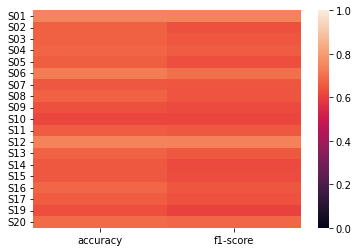

     class0 f1-score  class1 f1-score
S01         0.819383         0.568421
S02         0.779528         0.317073
S03         0.773946         0.351648
S04         0.779783         0.371134
S05         0.779528         0.282051
S06         0.823529         0.384615
S07         0.752941         0.411215
S08         0.778182         0.357895
S09         0.749091         0.316832
S10         0.723077         0.379310
S11         0.767347         0.359551
S12         0.814516         0.557692
S13         0.775665         0.378947
S14         0.769231         0.292135
S15         0.766423         0.304348
S16         0.788530         0.321839
S17         0.769231         0.329412
S19         0.748148         0.306122
S20         0.784615         0.440000


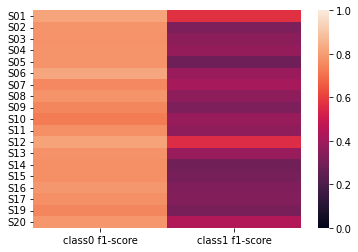

In [8]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [9]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [10]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [11]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

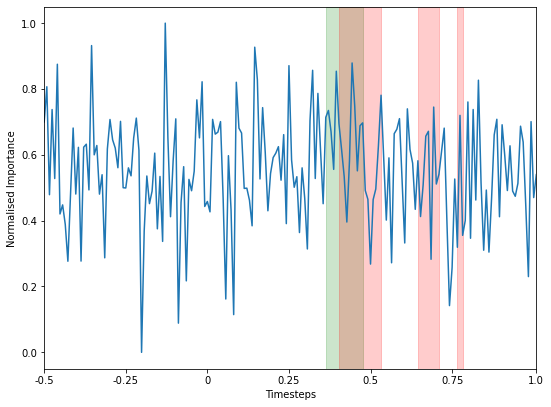

In [12]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)
# df.index= channel_names
# df.columns=timestep_labels


plt.plot(df)
# plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

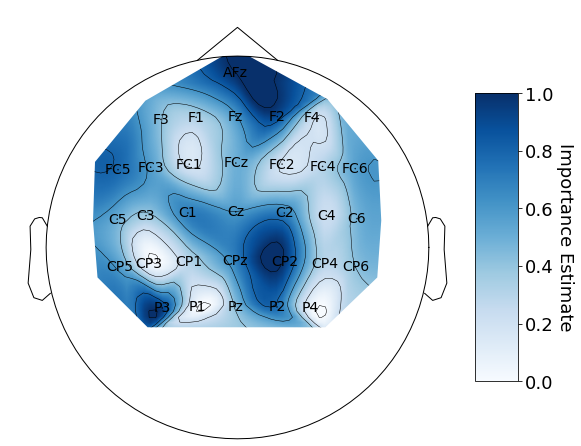

In [13]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)